#### authors: Rafael Dousse, Eva Ray, Massimo Stefani

# Exercise 1.b - Stochastic gradient ascent

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import sigma
from sklearn.linear_model import SGDClassifier

## Exercise steps

### a. Logistic regression classifier with linear decision boundary

#### a) Read the data from file

In a similar way as for the exercise of the previous week, read the training data from file `student-dataset-train.csv`. The first two columns are $x_{1}$ and $x_{2}$. The last column holds the class label $y$. Build the design matrix $X$ as follow:

$$X = \left(\begin{array}{ccc} 
        1 &   x_{1,1} & x_{1,2} \\
        1 &   \vdots  & \vdots  \\
        1 &   x_{N,1} & x_{N,2}
           \end{array}\right)$$

Check that the shape of $X$ is (100,3) and that the shape of $y$ is (100,).

In [2]:
def read(file):
    data = pd.read_csv(file, names=['x1', 'x2', 'y'])
    X = data[['x1', 'x2']].values
    y = data['y'].values
    return X, y

In [3]:
train_file = 'student-dataset-train.csv'
test_file = 'student-dataset-test.csv'

X_train, y_train = read(train_file)
X_test, y_test = read(test_file)

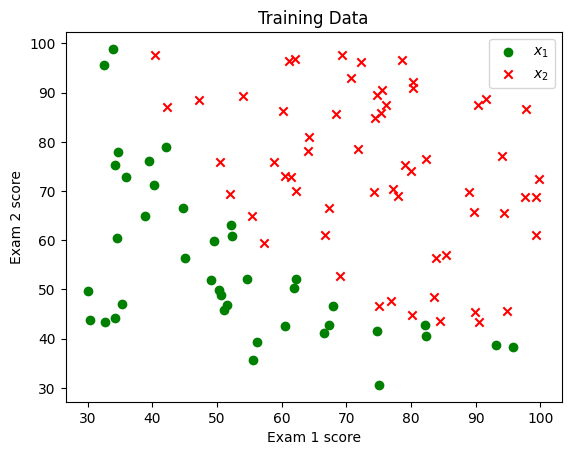

In [4]:
# Visualize the training data
plt.scatter(X_train[y_train==0][:,0], X_train[y_train==0][:,1], color='green', label='${x_1}$')
plt.scatter(X_train[y_train==1][:,0], X_train[y_train==1][:,1], marker='x', color='red', label='${x_2}$')
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.title('Training Data')
plt.legend()
plt.show()

In [5]:
# Add first column of ones to X_train and X_test
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [6]:
# print shapes of X and y to verify their correctness
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)

Shape of X_train: (100, 3)
Shape of y_train: (100,)
Shape of X_test: (100, 3)
Shape of y_test: (100,)


#### b) Implement a z-norm normalization of the training set

You need to store the normalization values $(\mu, \sigma)$ for later as they will be needed to normalize the test set.

In [7]:
def normalize(x, mu=None, sigma=None):
    if mu is None:
        mu = np.mean(x, axis=0)
    if sigma is None:
        sigma = np.std(x, axis=0)
    x_norm = (x - mu) / sigma
    return x_norm, mu, sigma

In [8]:
# Normalize training data (excluding the first column of ones)
X_train[:, 1:], mu, sigma = normalize(X_train[:, 1:])
# Normalize test data using training mu and sigma
X_test[:, 1:], _, _ = normalize(X_test[:, 1:], mu, sigma)

#### c) Implement a sigmoid function $g(z) = \frac{1}{1+e^{-z}}$

Use numpy to compute the exp so that your function can take numpy arrays as input. Check your implementation by plotting the sigmoid function.

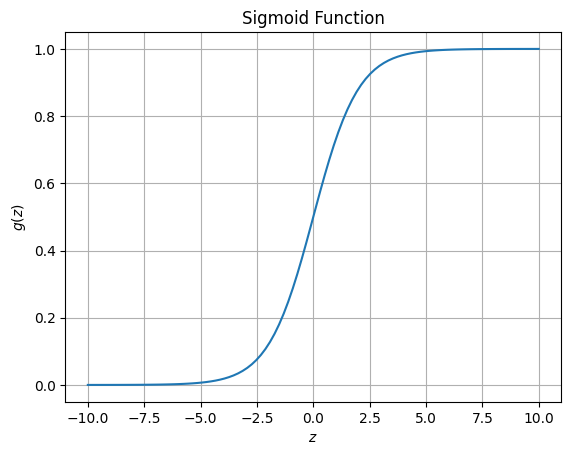

In [9]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

# Plot the sigmoid function to verify it is correct
z = np.linspace(-10, 10, 100)
plt.plot(z, sigmoid(z))
plt.title('Sigmoid Function')
plt.xlabel('$z$')
plt.ylabel('$g(z$)')
plt.grid()
plt.show()

#### d) Implement the hypothesis function $h_{\theta}(\mathbf{x})$

Hint: implement it so that the computation can take the full array $X$ with $h(\mathbf{x})$ broadcasted to all training samples.

In [10]:
# Taking inspiration form slide 25 of week 6 lecture
def hypothesis(X, theta):
    # X has shape (N, d) and theta has shape (d,)
    # The dot product is the broadcasted to all samples in X
    z = np.dot(X, theta)
    return sigmoid(z)

#### e) Implement the objective function $J(\theta)$

$$J(\theta) = \frac{1}{N} \sum_{n=1}^{N} y_{n} \log h_{\theta}(\mathbf{x_{n}}) + (1-y_{n}) \log (1 - h_{\theta} (\mathbf{x_{n}}))$$

In [11]:
# Taking inspiration form slide 26 of week 6 lecture
def objective(X, y, theta):
    epsilon = 1e-6
    h = hypothesis(X, theta) # h has shape (N,)
    N = X.shape[0]
    tmp = y * np.log(h + epsilon) + (1 - y) * np.log(1 - h + epsilon)
    return np.sum(tmp) / N

#### f) Implement the gradient ascent

In a similar way as in PW02 and PW03, implement the gradient ascent with the update rule:

$$\theta_{i} \leftarrow \theta_{i} + \alpha \frac{1}{N} \sum_{n=1}^{N} (y_{n} - h_{\theta}(\mathbf{x}_{n})) x_{n,i}$$

In [12]:
def stoch_gradient_ascent(X, y, learning_rate, num_epoch, hypothesis, objective, 
                         batch_size=1, convergence_delta=1e-6, track_per_batch=False):
    N, D = X.shape
    theta = np.zeros(D)
    J = [objective(X, y, theta)]
    J_epochs = [J[0]]
    
    for epoch in range(num_epoch):
        indices = np.random.permutation(N)
        X_shuffled, y_shuffled = X[indices], y[indices]
        
        for i in range(0, N, batch_size):
            X_batch = X_shuffled[i:i+batch_size]
            y_batch = y_shuffled[i:i+batch_size]
            h = hypothesis(X_batch, theta)
            error = y_batch - h
            gradient = np.dot(X_batch.T, error) / batch_size
            theta += learning_rate * gradient
            
            if track_per_batch:
                J.append(objective(X, y, theta))
        
        J_epoch = objective(X, y, theta)
        J_epochs.append(J_epoch)
        if not track_per_batch:
            J.append(J_epoch)
        
        if len(J_epochs) > 1 and abs(J_epochs[-1] - J_epochs[-2]) < convergence_delta * abs(J_epochs[-2]):
            break
    
    return theta, J

#### g) Test your implementation by running a gradient ascent

Hints: use a small $\alpha$. e.g. $0.001$,  store the evolution of the objective function $J(\theta)$ during the epochs to make a plot, use a large number of epochs, e.g. $2000000$.

Learned parameters (theta): [1.64362678 3.83360543 3.57108229]


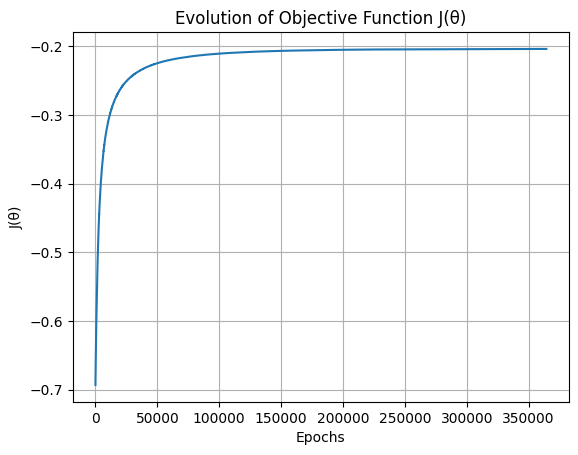

In [13]:
theta, J = stoch_gradient_ascent(X_train, y_train, learning_rate=0.001, num_epoch=2000000, hypothesis=hypothesis, objective=objective, track_per_batch=True)

# Print theta values after training
print("Learned parameters (theta):", theta)
# Plot the evolution of the objective function
plt.plot(J)
plt.title('Evolution of Objective Function J(θ)')
plt.xlabel('Epochs')
plt.ylabel('J(θ)')
plt.grid()
plt.show()

We can see that the objective function increases and converges over time, indicating that the gradient ascent is working correctly.

In [14]:
theta

array([1.64362678, 3.83360543, 3.57108229])

We can see that the theta that we obtained is quite different from the one obtained with the batch gradient ascent in the previous exercise. This is expected as the two methods optimize the objective function differently. But are quite similar.

#### h) Compute the correct classification rate on `student-dataset-test.csv`

Compute the correct classification rate on `student-dataset-test.csv` after convergence as you have an estimator of the posterior probabilities with:

$$P(y_{n}=1|\mathbf{x_{n}};\theta) = h_{\theta}(\mathbf{x_{n}})$$
$$P(y_{n}=0|\mathbf{x_{n}};\theta) = 1 - h_{\theta}(\mathbf{x_{n}})$$

This means that you can take the decisions $\hat{y}_{n} = 1$ if $h_{\theta}(\mathbf{x_{n}}) \geq 0.5$ and $\hat{y}_{n} = 0$ if $h_{\theta}(\mathbf{x_{n}}) < 0.5$.

In [15]:
def predict(X, theta):
    probs = hypothesis(X, theta)
    return (probs >= 0.5).astype(int)

y_pred = predict(X_test, theta)
accuracy = np.mean(y_pred == y_test)
print(f"Correct classification rate on test set: {accuracy * 100:.2f}%")

Correct classification rate on test set: 89.00%


Interesting to see that even if the two methods (batch and stochastic gradient ascent) lead to different theta values, the classification rates is the same.

#### i) Draw the decision boundary

Draw the decision boundary of your system on top of the scatter plot of the testing data.

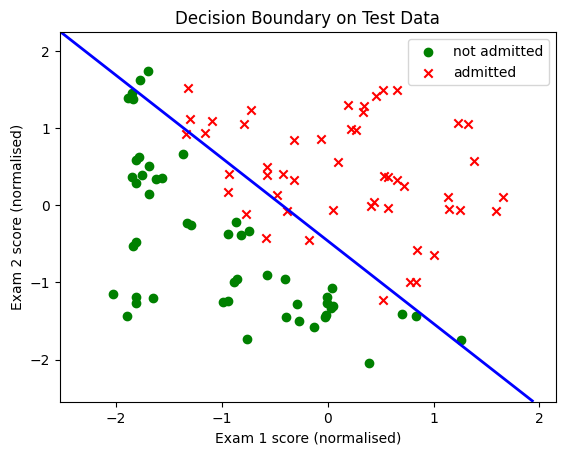

In [16]:
# Display test data
plt.scatter(X_test[y_test==0][:,1], X_test[y_test==0][:,2], color='green', label='not admitted')
plt.scatter(X_test[y_test==1][:,1], X_test[y_test==1][:,2], marker='x', color='red', label='admitted')

# Grid for decision boundary
x1_min, x1_max = X_test[:,1].min()-0.5, X_test[:,1].max()+0.5
x2_min, x2_max = X_test[:,2].min()-0.5, X_test[:,2].max()+0.5
grid_x1, grid_x2 = np.meshgrid(np.linspace(x1_min, x1_max, 200), np.linspace(x2_min, x2_max, 200))

# Compute decision boundary
decision_line = sigmoid(theta[0] + theta[1] * grid_x1 + theta[2] * grid_x2)

# Plot decision boundary
plt.contour(grid_x1, grid_x2, decision_line, levels=[0.5], linewidths=2, colors='blue')
plt.xlabel('Exam 1 score (normalised)')
plt.ylabel('Exam 2 score (normalised)')
plt.title('Decision Boundary on Test Data')
plt.legend()
plt.show()

We can see that the decision boundary separates the two classes quite well, while some misclassifications still occur. That said, it looks impossible to perfectly separate the two classes with a linear decision boundary, we could try a more complex model.

#### j) Compare the performance

Compare the performance of the logistic regression system with the ones of previous's week.

In [17]:
print(f"Correct classification rate on test set: {accuracy * 100:.2f}%")

Correct classification rate on test set: 89.00%


Compared to the other models used for classification in previous weeks, logistic regression performs quite well. It achieves a classification rate of around 89%, which shows that it is effective for this type of binary classification problem. The linear decision boundary is a limitation, but the model still captures the underlying patterns in the data reasonably well. To get even better performance, we could consider using a more complex model with non-linear decision boundaries.